In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

## Конфигурация

In [2]:
config = dict(
    n_epochs=5000,
    batch_size=128,
    learning_rate=0.0005
)

## Dataset

In [3]:
class SiameseDataset(torch.utils.data.Dataset):

    def __init__(self, path, x_file='x.pt', y_file='y.pt'):
        self.x = torch.load(path + '/' + x_file)
        self.y = torch.load(path + '/' + y_file)
        
        if self.x.shape[0] != self.y.shape[0]:
            raise RuntimeError(f'Tensors X and Y must have the same number of items.')

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx][0], self.x[idx][1], self.y[idx]

## Нейронная сеть

In [4]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3)
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(8*30, 8),
            torch.nn.ReLU()
        )

    def forward_once(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def forward(self, x_1, x_2):
        out_1 = self.forward_once(x_1)
        out_2 = self.forward_once(x_2)

        return out_1, out_2

## Контрастная функция потерь

In [5]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, out_1, out_2, y):
        euclidean_distance = torch.nn.functional.pairwise_distance(out_1, out_2, keepdim = True)
        
        loss_contrastive = torch.mean((1 - y) * torch.pow(euclidean_distance, 2) +
                                      (y) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive

## Обучение нейросети

#### Подготовка Dataset и DataLoader

In [6]:
train_dataset = SiameseDataset(path='siamese_data/train')

In [7]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               shuffle=True,
                                               batch_size=config['batch_size'])

#### Обучение

In [8]:
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [9]:
loss_history = []
lr_history = []

epoch_progress = trange(config['n_epochs'])
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch + 1}')

    for i, (x_1, x_2, y) in enumerate(train_dataloader):
        out_1, out_2 = model(x_1, x_2)

        loss = criterion(out_1, out_2, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lr_history.append(optimizer.param_groups[0]['lr'])
        loss_history.append(loss.item())
        
        epoch_progress.set_postfix({'loss': loss.item()})

    if epoch % 1500 == 0 and epoch > 0:
        optimizer.param_groups[0]['lr'] *= 0.1

  0%|          | 0/5000 [00:00<?, ?it/s]

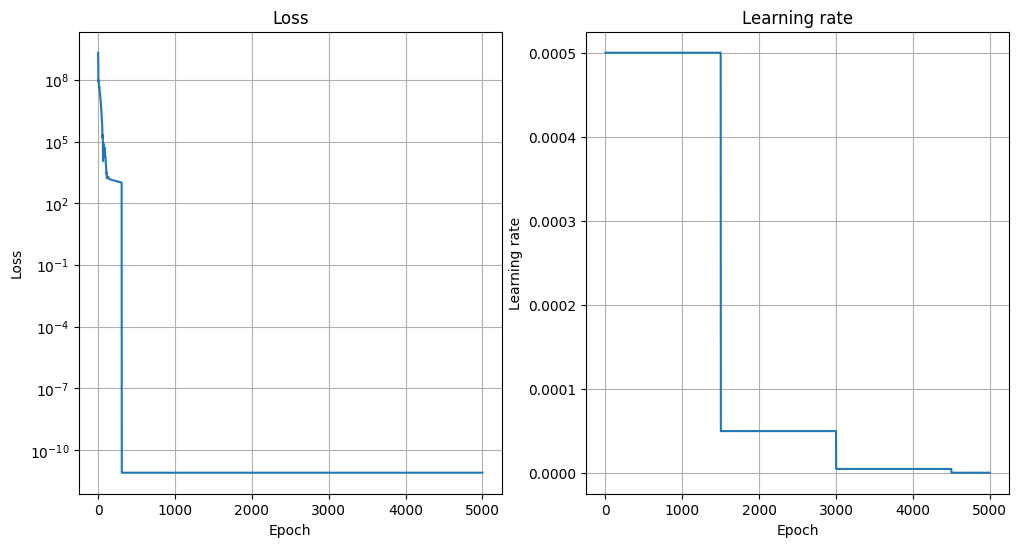

In [10]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Loss plot
axis[0].set_title('Loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].semilogy()
axis[0].grid()
axis[0].plot(loss_history)

# Learning rate plot
axis[1].set_title('Learning rate')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Learning rate')
axis[1].grid()
axis[1].plot(lr_history)

## Тестирование нейросети

#### Подготовка Dataset и DataLoader для тестирования

In [11]:
# test_dataset = SiameseDataset(path='siamese_data/test')

# Заглушка
test_dataset = SiameseDataset(path='siamese_data/train')

In [12]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=config['batch_size'])

#### Расчет метрик

In [13]:
losses = []

for i, (x_1, x_2, y) in enumerate(test_dataloader):
    with torch.inference_mode():
        out_1, out_2 = model(x_1, x_2)
        
        loss = criterion(out_1, out_2, y)
        
        losses.append(loss.item())

print(f'Loss on test = {np.mean(losses)}')

Loss on test = 7.99999910067184e-12
